In [100]:
import sys
stdout = sys.stdout
import matplotlib
%matplotlib inline
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import controlledgate
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator

import warnings
warnings.simplefilter('ignore')

In [101]:
#fix output
sys.stdout = stdout
simulator = QasmSimulator()

In [102]:
def assert_correct_counts(counts, expected_value):
    keys = counts.keys()
    if expected_value == list(keys)[0]:
        print('✅ Correct prediction 🎉')
    else:
        print('❌ False assertion, maybe there are also more than 1 results! 😥')

def compile_circuit_and_check(circuit, expected_value):
    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=3000)
    result = job.result()
    counts = result.get_counts(circuit)
    assert_correct_counts(counts, expected_value)
    return counts

# Vector-Operations



# Circuit to add 2 qubits together

Due to the nature of quantum gates, one is not able to simply copy the classical design of a [half-](https://en.wikipedia.org/wiki/Adder_(electronics)#Half_adder) or even [fulladder](https://en.wikipedia.org/wiki/Adder_(electronics)#Full_adder) over to a general quantum computer. This means we have to construct something applicable, that can do the same for us.

## Creating a simple 2 qubit adder

Qubits are usually represented as _vectors_, and the qubit states $\ket{0}$ and $\ket{1}$ are represented as $\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ and $\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, respectively.

When working with more than 1 qubit, we can resemble the statespace as one large vector. With 2 qubits, we have 4 possible states $S$ can be in: "00, 01, 10, 11". This means we can represent the whole state-space with one simple vector:

$$
S = \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0\end{pmatrix}
$$

Where the _1_ in the vector would represent $\ket{01}$.

In this case, we only have one state that would cause any change when doing _addition_. The state to trigger it would be $\ket{11}$, and it's addition would result in $\ket{00}$ with a carry of _1_, which we will ignore for now.

To create a matrix (which we will call $U_{add}$ from now on) that allows the addition of 2 qubits, we can set up equations with our current knowledge:

$$

U_{add} *\ \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0\end{pmatrix} = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0\end{pmatrix} \\
U_{add} *\ \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0\end{pmatrix} = \begin{pmatrix} 0 \\ 1 \\ 0 \\ 0\end{pmatrix} \\
U_{add} *\ \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0\end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0\end{pmatrix} \\
U_{add} *\ \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1\end{pmatrix} = \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0\end{pmatrix} \\

$$

To find the matrix needed, we can simply multiply the output $O_n$ with the transposed input state $S_n$ to get $U_n$. To create the definitive matrix, we then just add all the resulting matrices together to receive $U_{add}$.

$$
O_0 * S_0^T = U_{0} = \begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} \\
O_1 * S_1^T = U_{1} = \begin{pmatrix} 0 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} \\
O_2 * S_2^T = U_{2} = \begin{pmatrix} 0 & 0 & 0 & 0\\ 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} \\
O_3 * S_3^T = U_{3} = \begin{pmatrix} 0 & 0 & 0 & 1\\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} \\
$$

Now we can add up all matrices to get $U_{add}$

$$
U_{add} = \Sigma_{i=0}^{3} U_{i} = \begin{pmatrix} 1 & 0 & 0 & 1\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix}

$$

_If you can't figure out why our unitary gate is left of the state, check [this]() out_ <- todo, insert how gates are applied to a qubit

Qiskit offers the possibility to create an unitary gate that can be defined using a matrix. Whilst we could just plug the matrix right in, we have to make sure that the matrix is unitary, as all quantum gates have to be unitary. To check if a matrix is unitary, we have the following equation which has to be fulfilled:

$$

U^{\dagger}U =\ UU^{\dagger} = I\\
U^{\dagger} =\ \overline{U^T}
$$

The _conjugate_ of the matrix would be multiplying all _imaginary constants_ wiht _-1_. As our matrix does not contain any, we can ignore this step. The next one would be to get the transpose of the matrix:

$$

U^T = \begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 1 & 0 & 0 & 0\end{pmatrix}

$$

From here we can then multiply $U$ with $U^T$ and see whether or not our matrix is unitary

$$

UU^T = \begin{pmatrix} 1 & 0 & 0 & 1\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} *\ \begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 1 & 0 & 0 & 0\end{pmatrix} =\ \begin{pmatrix} 2 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0\end{pmatrix} \neq \begin{pmatrix} 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{pmatrix}

$$

As we have shown, the matrix is not unitary. This is also confirmed through Qiskits self-check. 

In [103]:
# This requires us to import a specific part of the library
import qiskit.quantum_info as qi

addition = qi.Operator([[1, 0, 0, 1],
                        [0, 1, 0, 0],
                        [0, 0, 1, 0],
                        [0, 0, 0, 0]])

circuit = QuantumCircuit(2,2)
try:
    circuit.unitary(addition, [0,1], label="addition")
except:
    print('❌ Input matrix is not unitary. 😥')

❌ Input matrix is not unitary. 😥


# Toffoli Gate

The reason why this isn't an adequate matrix is because we "lose" the input information. In quantum circuits, gates have to be reversible, which means there cannot be a loss of information. This means, that for our addition, we have to add in _at least_ another qubit, so that we can apply the result on the last qubit. Due to this, our state vector now changes from a length of 4 to 8:

$$
S = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix}
$$

With this, we can apply the same calculations as above to retrieve a new $U_{add}$ matrix.

$$
U_{add} = \Sigma_{i=0}^{7} O_{i} *\ S_{i}^T = \begin{pmatrix}
        1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
        0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
        0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
        0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\
        0 & 0 & 0 & 1 & 0 & 0 & 0 & 0
        \end{pmatrix}
$$


This is equivalent to the _Toffoli_ Gate, also called a _CCNOT_ Gate. Let's test this with some gates


In [117]:
s = np.zeros((8,8))
for idx, val in enumerate(s):
    a = np.zeros(8)
    a[idx] = 1
    s[idx] = a.copy()

o = s.copy()
temp = o[-1].copy()
o[-1] = o[3].copy()
o[3] = temp.copy()

u = np.zeros((8,8))
for idx, val in enumerate(s):
    u = np.add(u, np.multiply(o[idx], np.transpose(val)))

print(u)


[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]
[[1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 0.]]


In [105]:
%matplotlib inline

state_matrix = [[0,0],
                [0,1],
                [1,0],
                [1,1]]

expected_states = ['000','101','110','011']

def generate_circuit(index):
    circuit = QuantumCircuit(3,3)
    if(state_matrix[index][1] == 1):
        circuit.x(0)
    if(state_matrix[index][0] == 1):
        circuit.x(1)
    circuit.barrier()
    circuit.ccx(0,1,2)
    circuit.x(2)
    circuit.barrier()
    circuit.measure(range(3),range(3)) 
    return circuit

Testing for initial state [0, 0] and expected measurment state 000


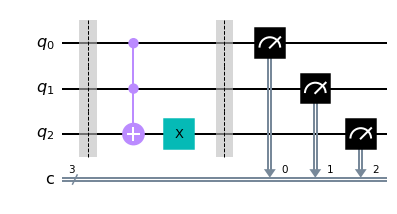

❌ False assertion, maybe there are also more than 1 results! 😥


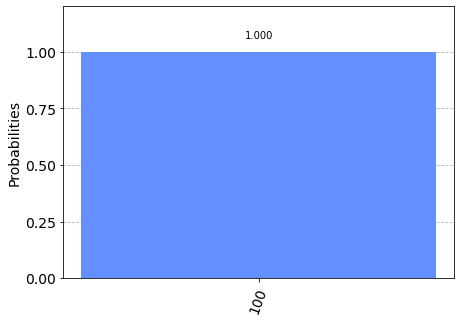

Testing for initial state [0, 1] and expected measurment state 101


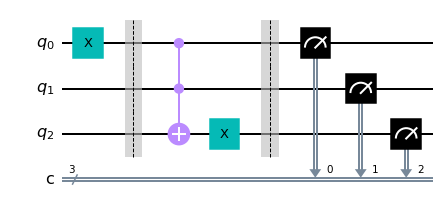

✅ Correct prediction 🎉


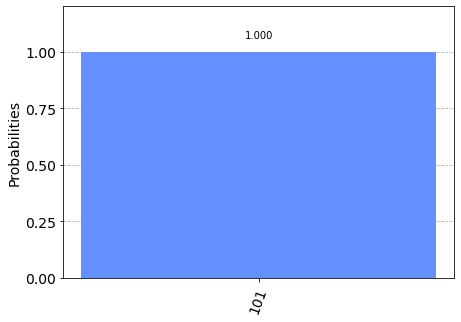

Testing for initial state [1, 0] and expected measurment state 110


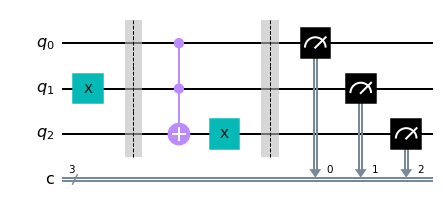

✅ Correct prediction 🎉


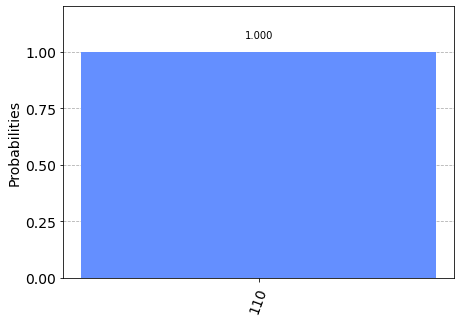

Testing for initial state [1, 1] and expected measurment state 011


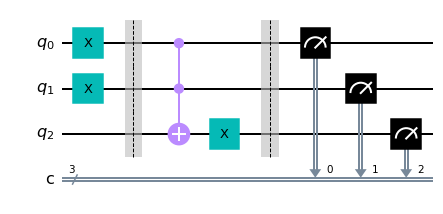

✅ Correct prediction 🎉


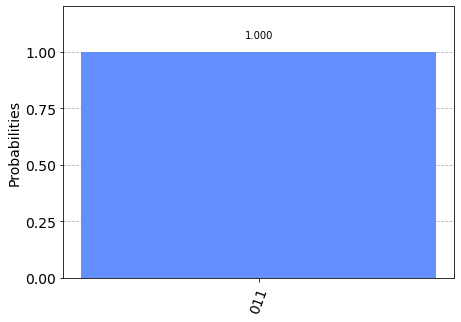

In [106]:
for index, expected_state in enumerate(expected_states):
    print("Testing for initial state " + str(state_matrix[index]) + " and expected measurment state " + expected_state)
    circuit = generate_circuit(index)
    display(circuit.draw('mpl'))
    display(plot_histogram(compile_circuit_and_check(circuit, expected_states[index])))

As we can see, the theory holds up and can be proven using the simulator. The next part would be to increase the amount of addable qubits from 1 + 1 to n + n.